In [35]:
import pyforest
import plotly
import cufflinks as cf
#Enabling the offline mode for interactive plotting locally
from plotly.offline import download_plotlyjs,init_notebook_mode,plot,iplot
init_notebook_mode(connected=True)
cf.go_offline()
#To display the plots
%matplotlib inline
import warnings
warnings.filterwarnings('ignore');
from sklearn.preprocessing import MinMaxScaler,StandardScaler,RobustScaler,OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.metrics import make_scorer
from sklearn.metrics import classification_report,confusion_matrix,plot_confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Ingest Data 

In [2]:
df = pd.read_csv("ready_for_preprocessing.csv")
df.head()

<IPython.core.display.Javascript object>

,atype,phase_of_flt,state,height,speed,effect,sky,species,birds_struck,month_of_the_year,season
0,FK-28-4000,Climb,South Atlantic,10.0,140.0,None,No Cloud,UNKNOWN BIRD - MEDIUM,2-10,November,Fall
1,B-727-200,Approach,East South Central,400.0,140.0,None,Some Cloud,UNKNOWN BIRD - SMALL,1,August,Summer
2,MD-82,Climb,South Atlantic,100.0,200.0,None,Overcast,UNKNOWN BIRD - SMALL,1,October,Fall
3,MD-82,Climb,South Atlantic,50.0,170.0,None,Some Cloud,UNKNOWN BIRD - SMALL,1,September,Fall
4,BE-99,Landing Roll,South Atlantic,0.0,40.0,None,Some Cloud,HAWKS,1,September,Fall


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13116 entries, 0 to 13115
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   atype              13116 non-null  object 
 1   phase_of_flt       13116 non-null  object 
 2   state              13116 non-null  object 
 3   height             13116 non-null  float64
 4   speed              13116 non-null  float64
 5   effect             13116 non-null  object 
 6   sky                13116 non-null  object 
 7   species            13116 non-null  object 
 8   birds_struck       13116 non-null  object 
 9   month_of_the_year  13116 non-null  object 
 10  season             13116 non-null  object 
dtypes: float64(2), object(9)
memory usage: 1.1+ MB


In [4]:
df.shape

(13116, 11)

## Drop duplicates
* just droped duplicates that have "None" on target column

In [5]:
df.duplicated().sum()

123

In [6]:
df.loc[df.duplicated()]["effect"].value_counts()

None                     120
Precautionary Landing      3
Name: effect, dtype: int64

In [7]:
drop_idx = df.loc[(df.duplicated())&(df.effect == "None")].drop_duplicates().index

In [8]:
df.drop(drop_idx, inplace=True)


In [9]:
df.shape

(13038, 11)

In [10]:
df.reset_index(drop=True,inplace=True)
df

,atype,phase_of_flt,state,height,speed,effect,sky,species,birds_struck,month_of_the_year,season
0,FK-28-4000,Climb,South Atlantic,10.0,140.0,None,No Cloud,UNKNOWN BIRD - MEDIUM,2-10,November,Fall
1,B-727-200,Approach,East South Central,400.0,140.0,None,Some Cloud,UNKNOWN BIRD - SMALL,1,August,Summer
2,MD-82,Climb,South Atlantic,100.0,200.0,None,Overcast,UNKNOWN BIRD - SMALL,1,October,Fall
3,MD-82,Climb,South Atlantic,50.0,170.0,None,Some Cloud,UNKNOWN BIRD - SMALL,1,September,Fall
4,BE-99,Landing Roll,South Atlantic,0.0,40.0,None,Some Cloud,HAWKS,1,September,Fall
...,...,...,...,...,...,...,...,...,...,...,...
13033,C-152,Climb,South Atlantic,50.0,65.0,Precautionary Landing,Some Cloud,UNKNOWN BIRD,1,October,Fall
13034,PA-38 TOMAHAWK,Take-off run,South Atlantic,0.0,120.0,Precautionary Landing,No Cloud,WHITE-TAILED DEER,1,June,Summer
13035,MD-80,Approach,East North Central,50.0,140.0,None,Some Cloud,UNKNOWN BIRD - MEDIUM,1,September,Fall
13036,LOCKHEED 188,Climb,New England,50.0,150.0,None,No Cloud,ROCK PIGEON,1,January,Winter


In [16]:
df[df.select_dtypes("object").columns] = df[df.select_dtypes("object").columns].astype("category")

In [20]:
df.height.max(), df.speed.max()

(32500.0, 400.0)

In [21]:
df[df.select_dtypes("float64").columns] = df[df.select_dtypes("float64").columns].astype("int32")

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13038 entries, 0 to 13037
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   atype              13038 non-null  category
 1   phase_of_flt       13038 non-null  category
 2   state              13038 non-null  category
 3   height             13038 non-null  int32   
 4   speed              13038 non-null  int32   
 5   effect             13038 non-null  category
 6   sky                13038 non-null  category
 7   species            13038 non-null  category
 8   birds_struck       13038 non-null  category
 9   month_of_the_year  13038 non-null  category
 10  season             13038 non-null  category
dtypes: category(9), int32(2)
memory usage: 259.7 KB


In [25]:
# conda install -c conda-forge sweetviz

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\madcat\anaconda3

  added / updated specs:
    - sweetviz


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2022.9.14  |       h5b45459_0         189 KB  conda-forge
    certifi-2022.9.14          |     pyhd8ed1ab_0         156 KB  conda-forge
    sweetviz-2.1.4             |     pyhd8ed1ab_0        13.2 MB  conda-forge
    ------------------------------------------------------------
                                           Total:        13.6 MB

The following NEW packages will be INSTALLED:

  sweetviz           conda-forge/noarch::sweetviz-2.1.4-pyhd8ed1ab_0

The following packages will be UPDATED:

  ca-certificates    pkgs/main::ca-certificates-2022.07.19~ --> conda-forge::ca-certificates-2022.9.14-h5b45459_0
  certifi            pkgs/main/win-64::certifi-2022.6.15-p~ --> c

                                             |                                             | [  0%]   00:00 ->…


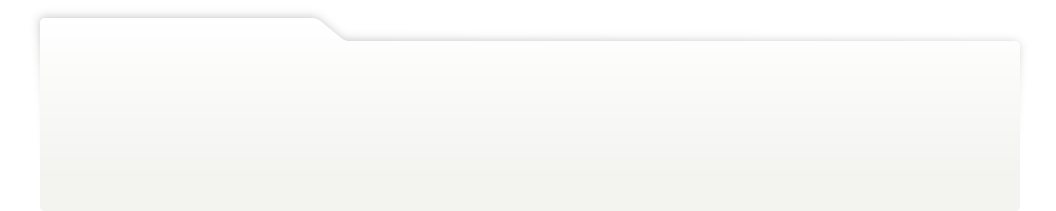
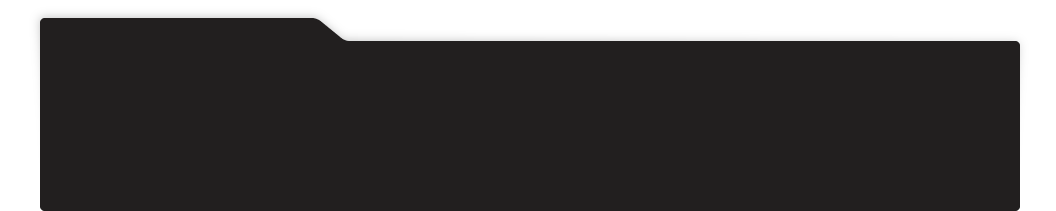
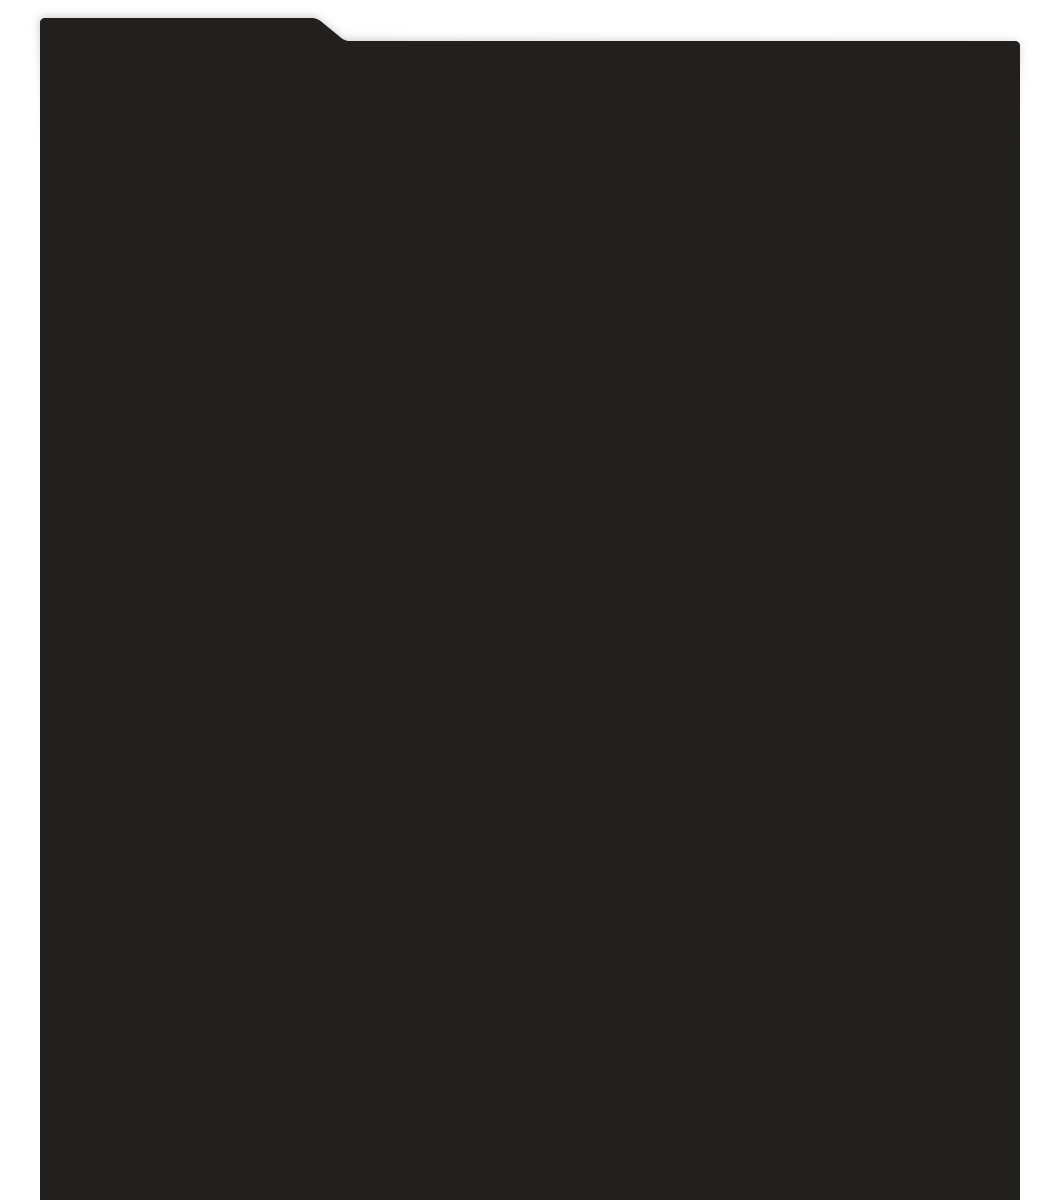
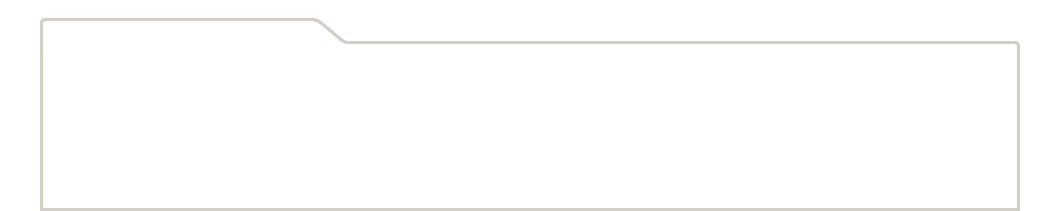
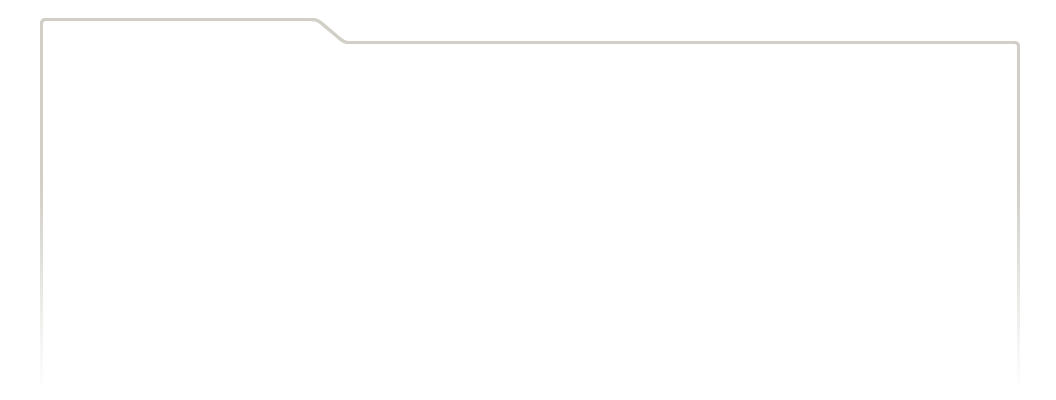
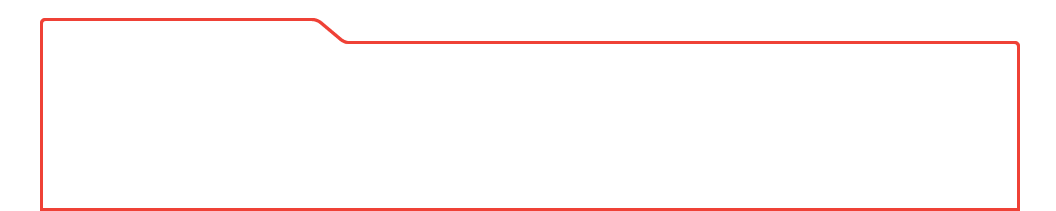
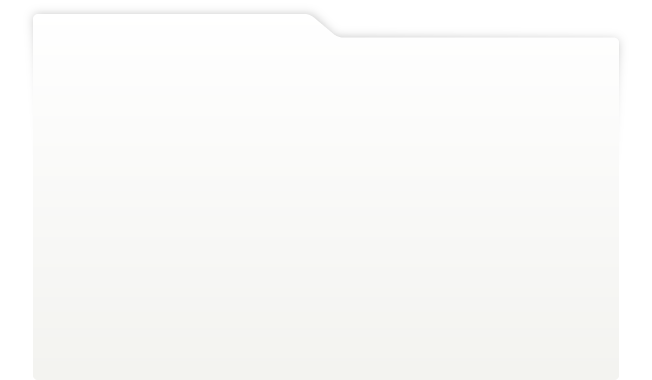
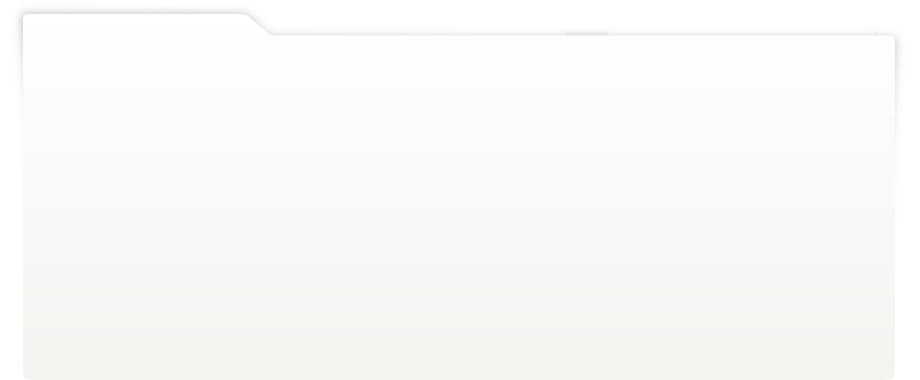
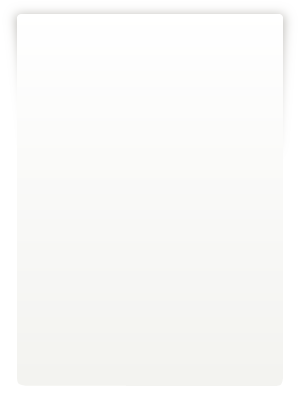
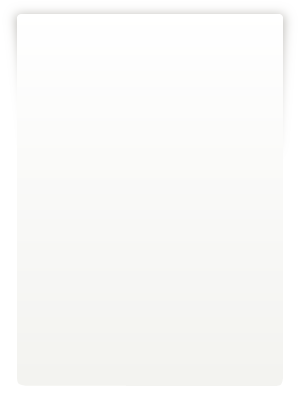
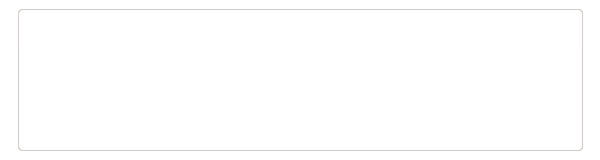
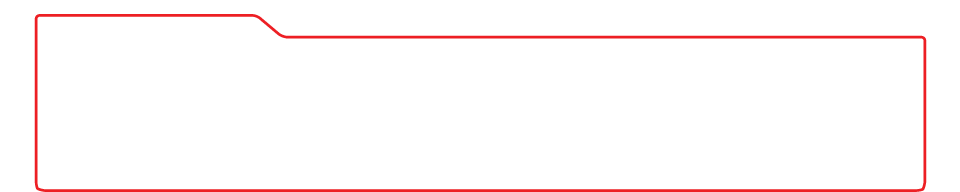
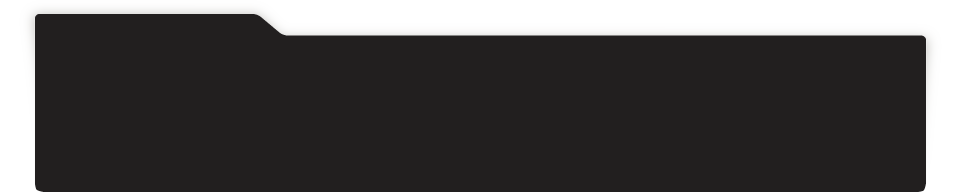
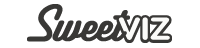
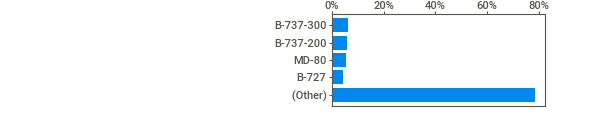
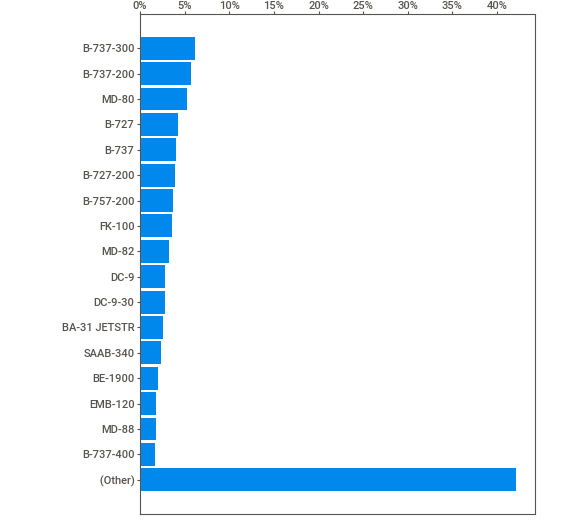
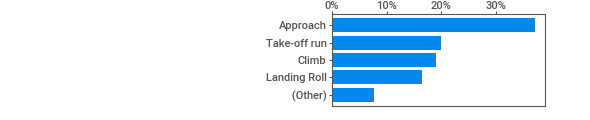
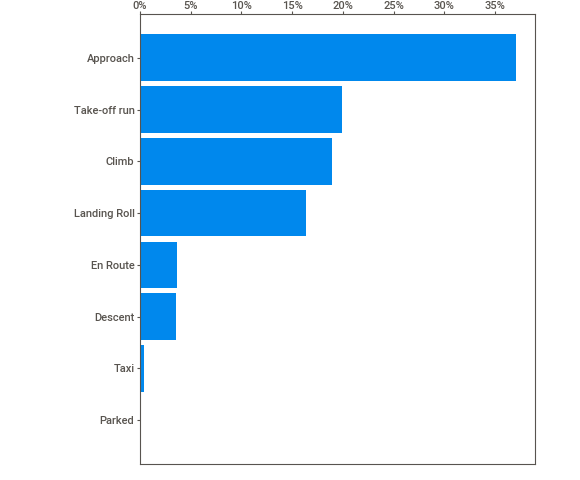
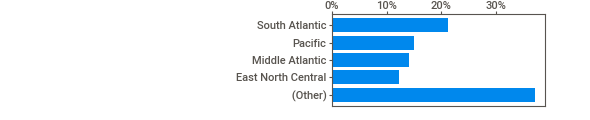
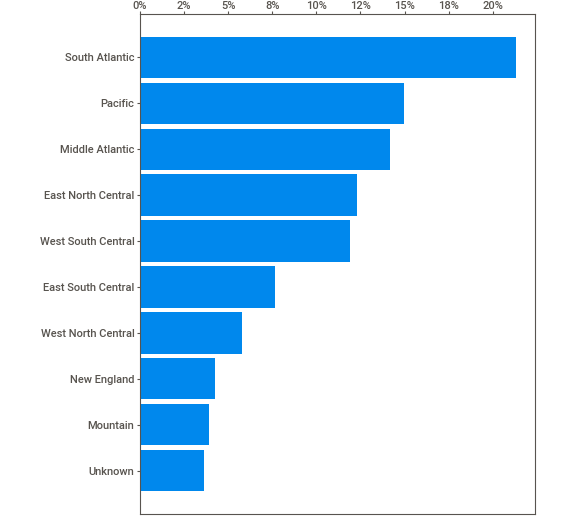
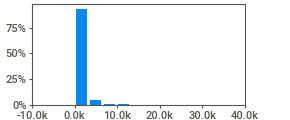
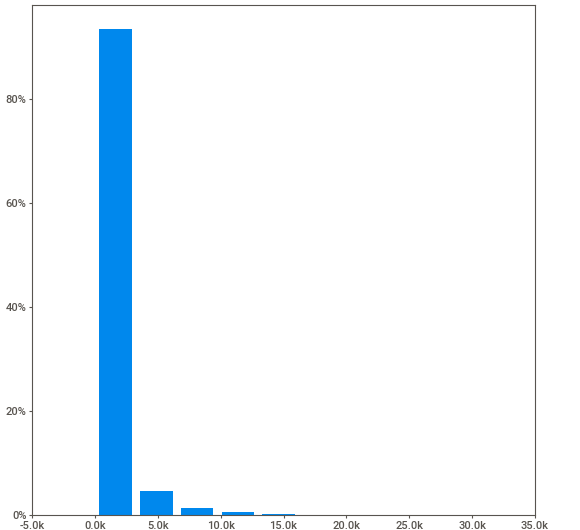
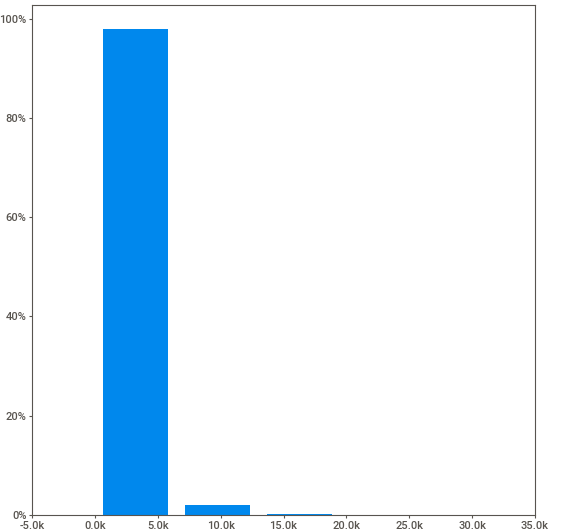
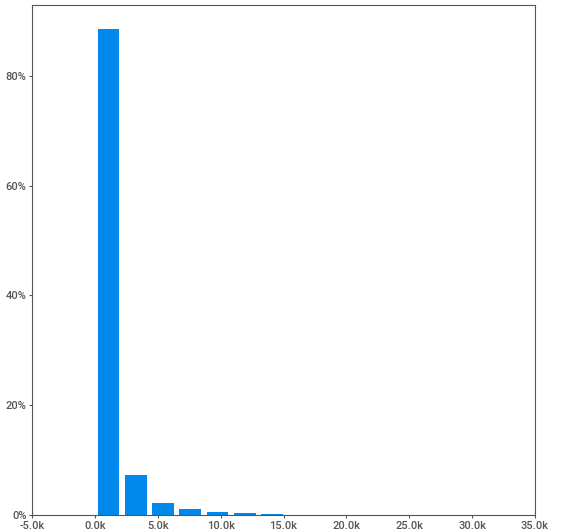
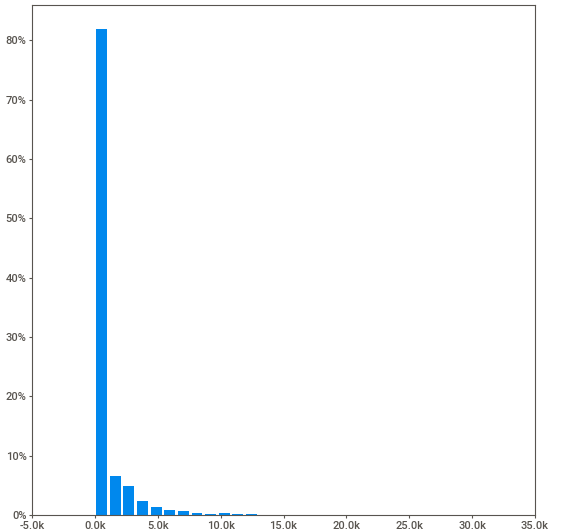
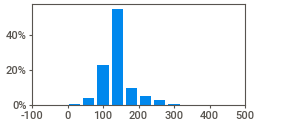
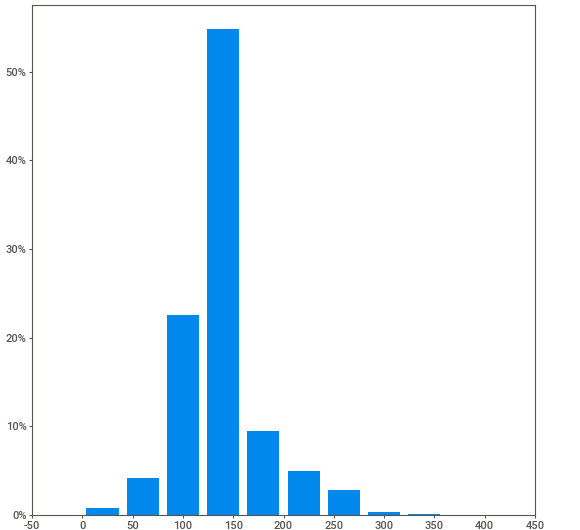
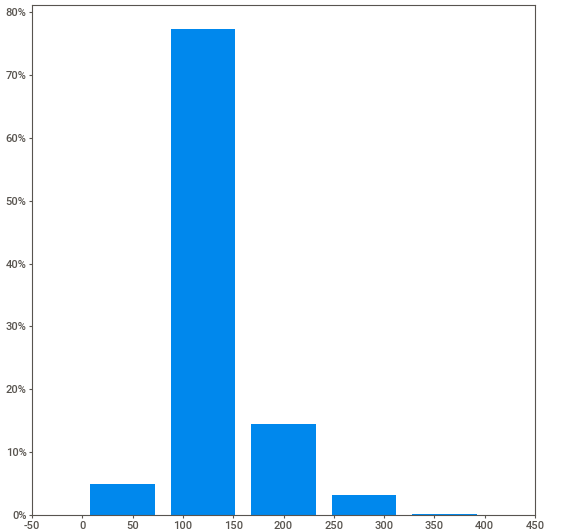
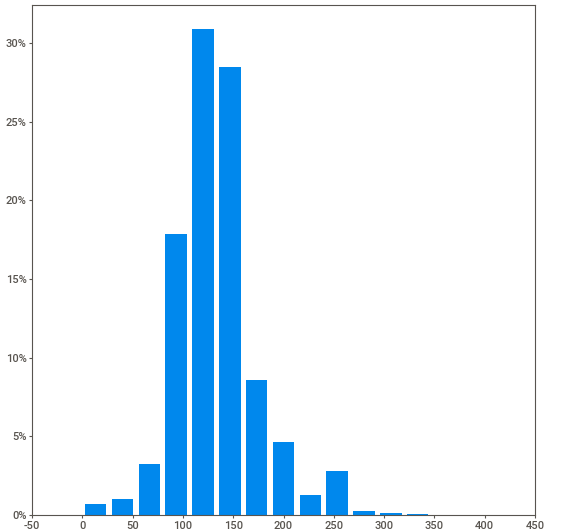
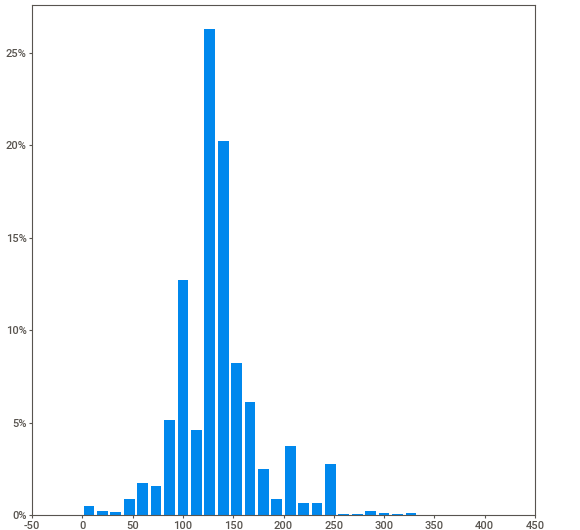
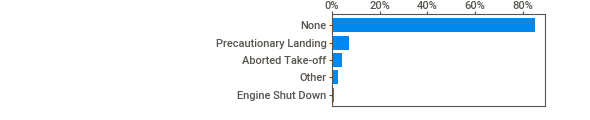
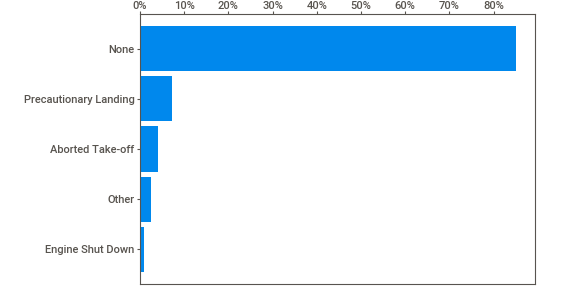
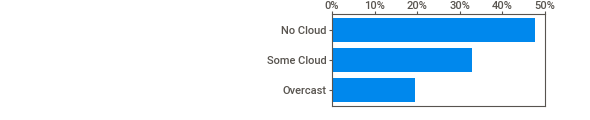
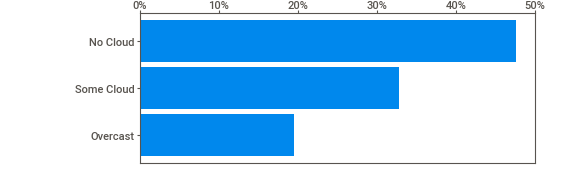
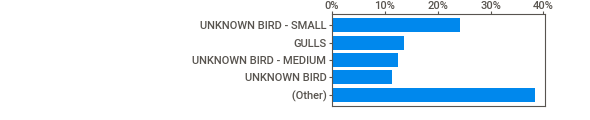
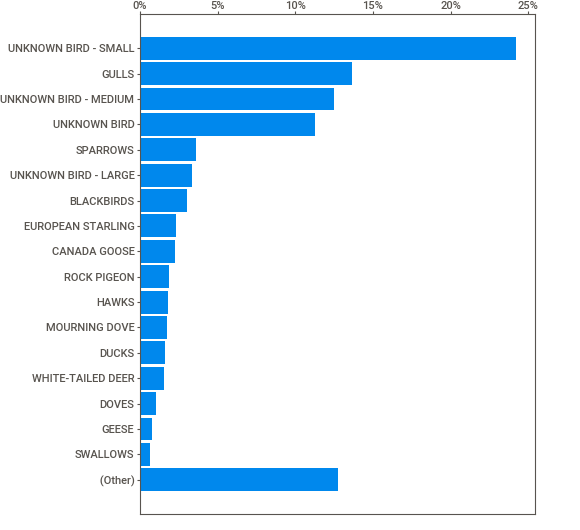
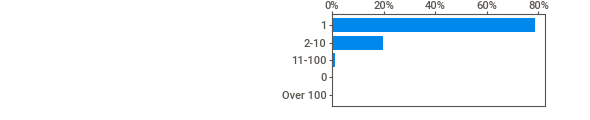
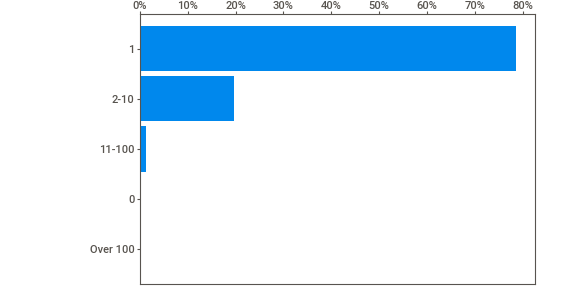
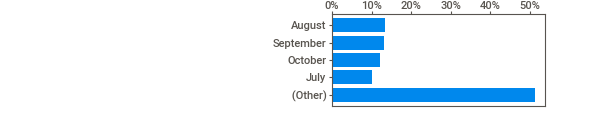
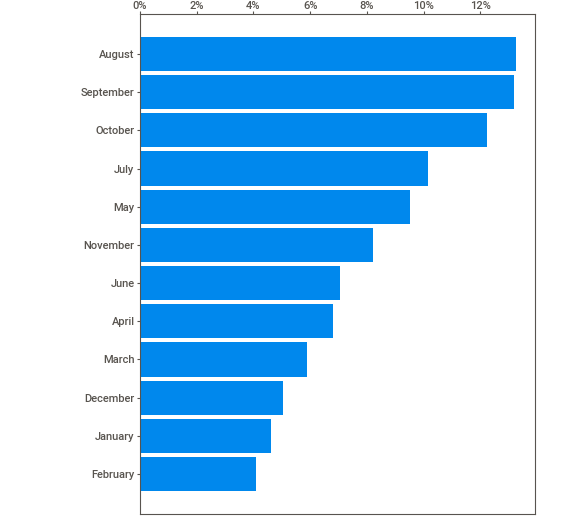
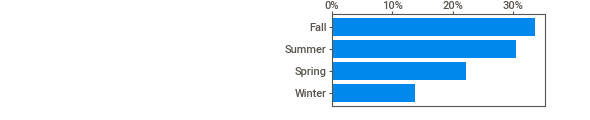
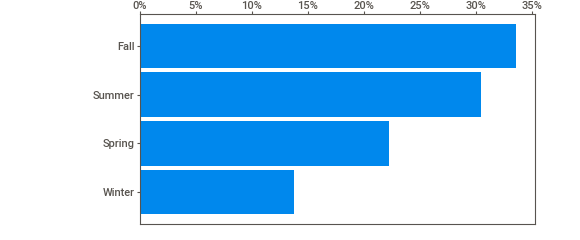
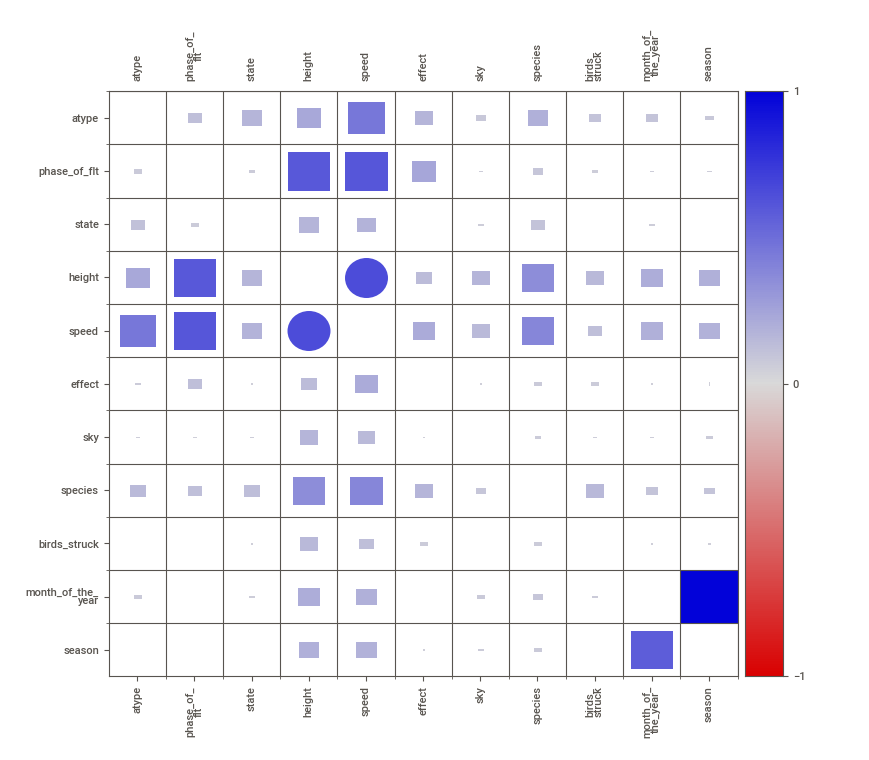
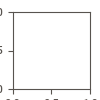

In [29]:
import sweetviz as sv

my_report = sv.analyze(df)
my_report.show_notebook() # Default arguments will generate to "SWEETVIZ_REPORT.html"

# Data Processing

In [30]:
X = df.drop("effect",axis=1)
y = df.effect

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.10, random_state=42)

<IPython.core.display.Javascript object>

                                             |                                             | [  0%]   00:00 ->…


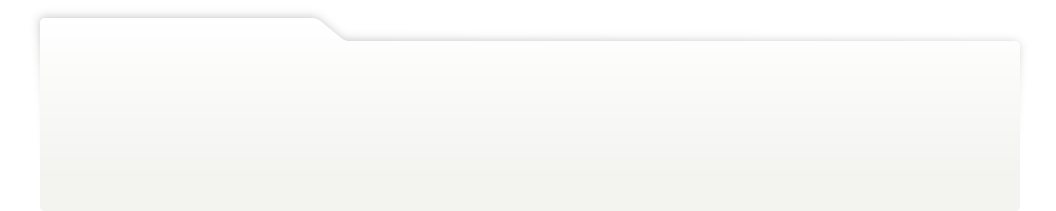
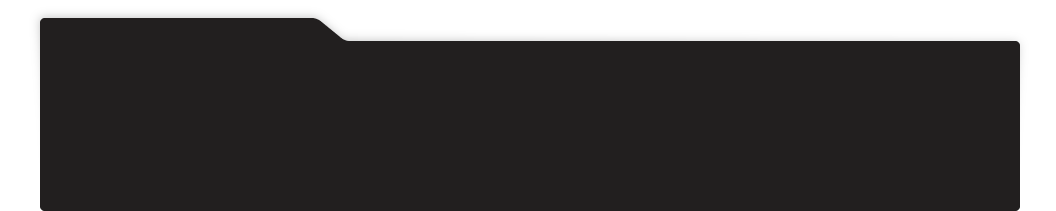
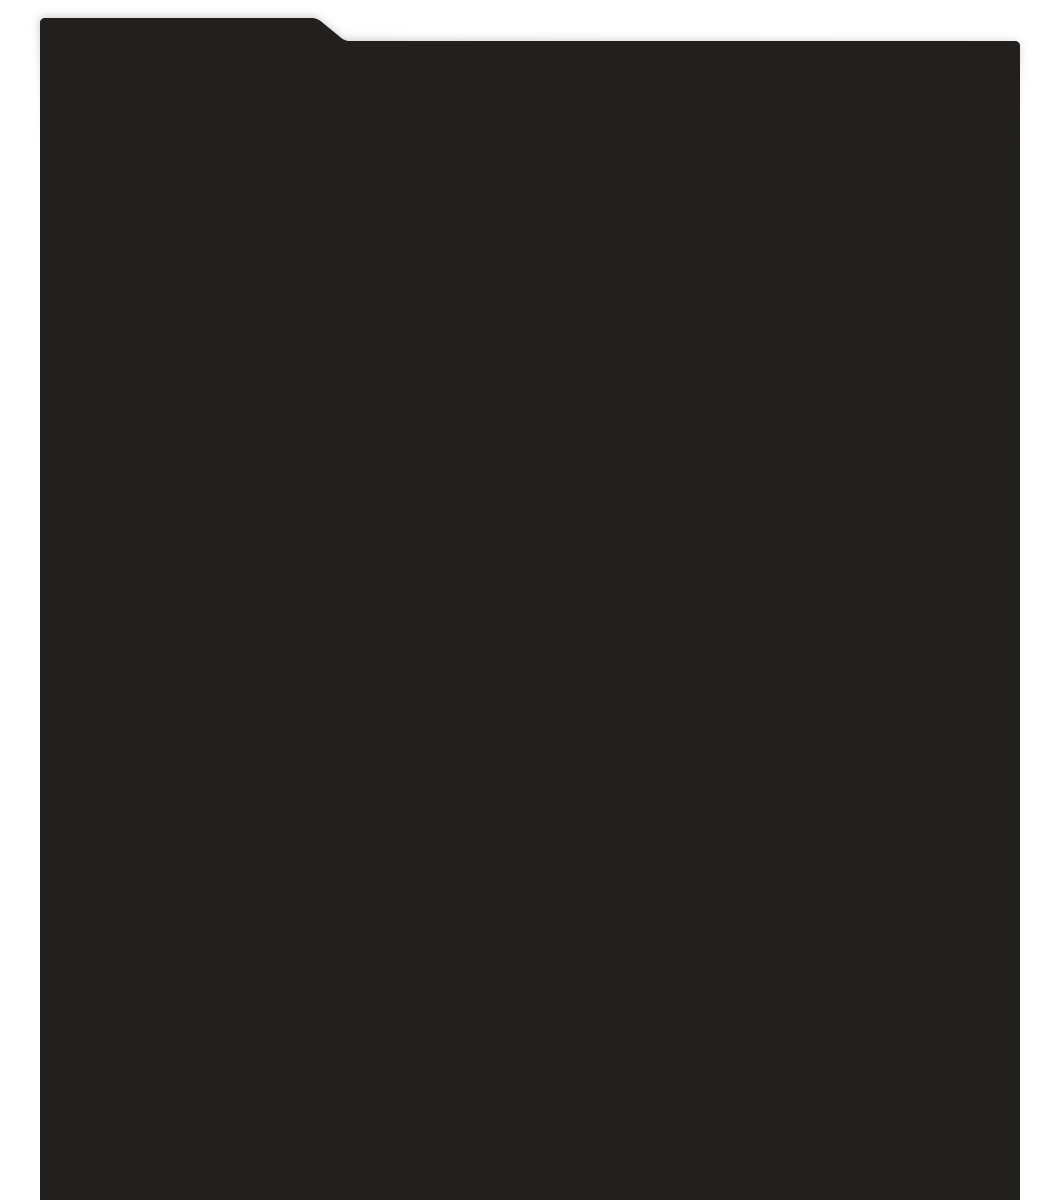
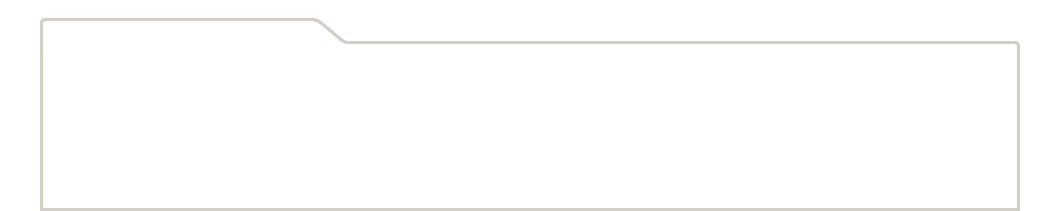
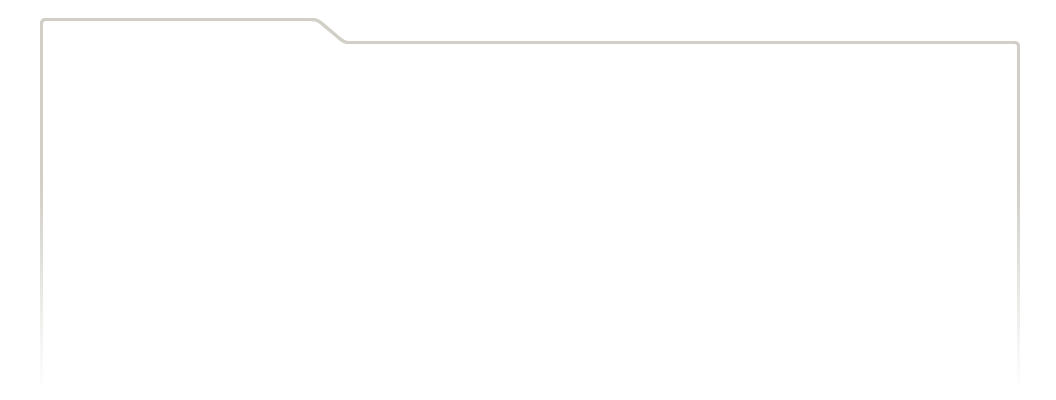
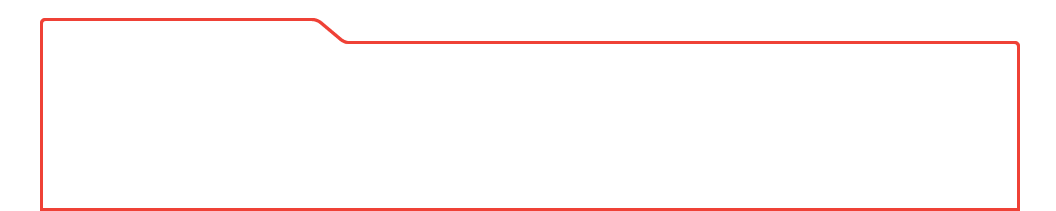
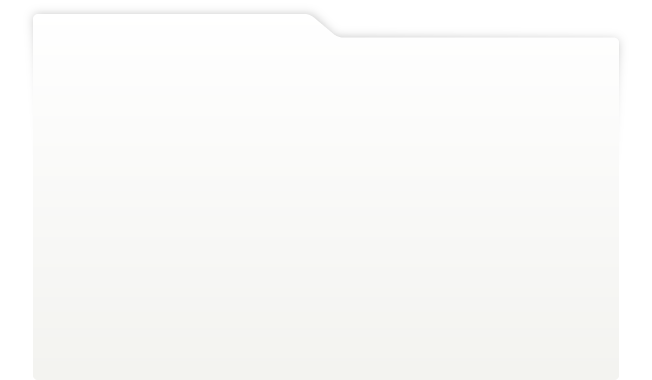
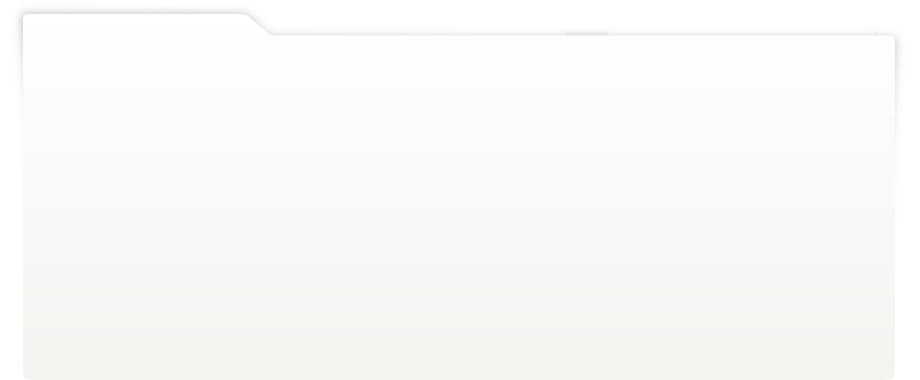
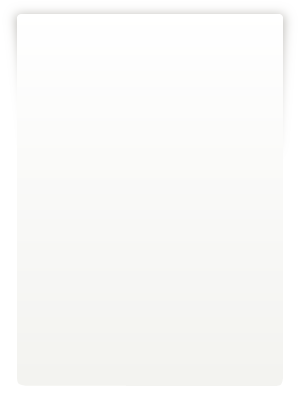
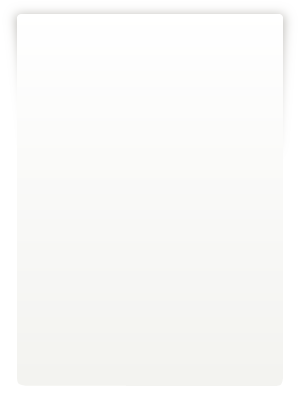
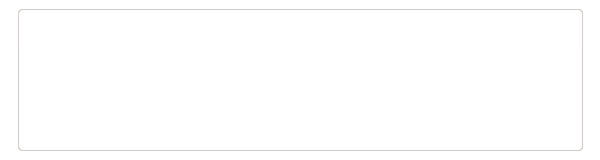
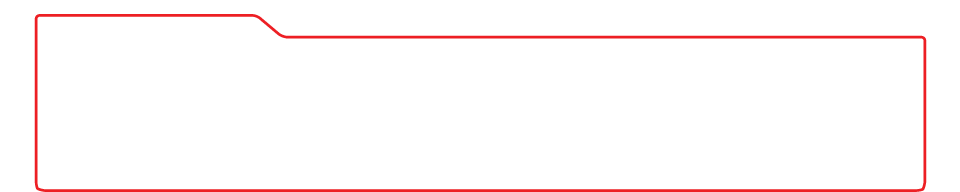
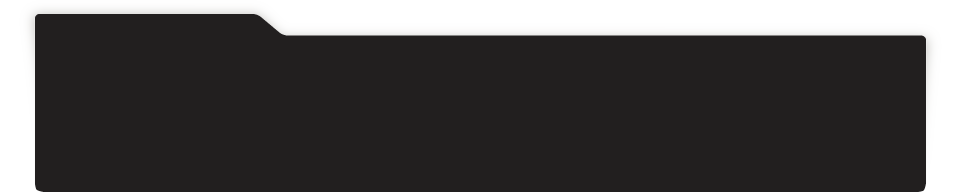
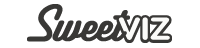
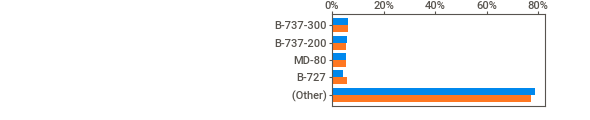
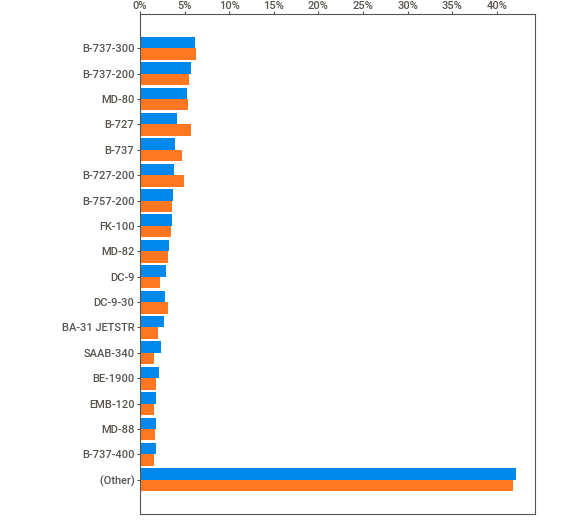
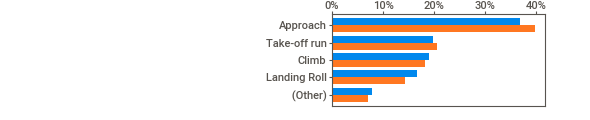
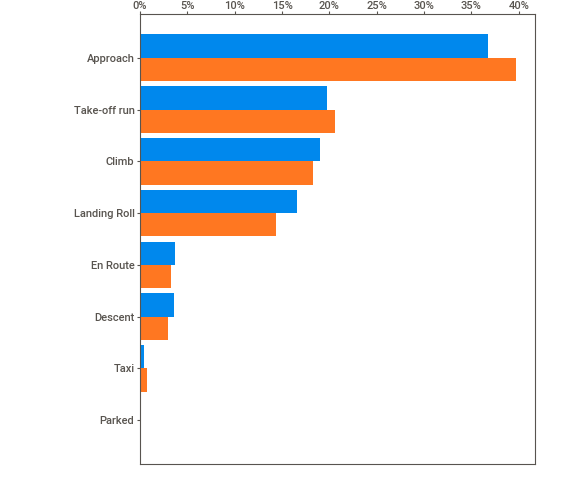
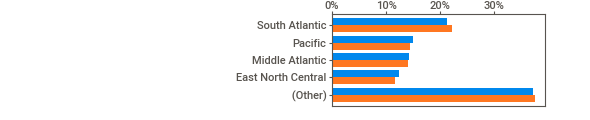
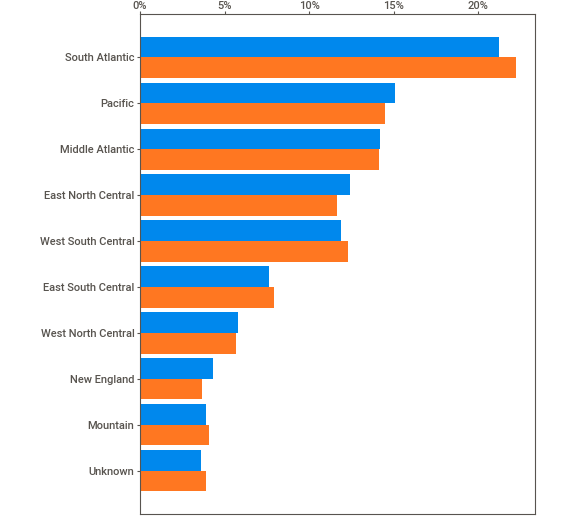
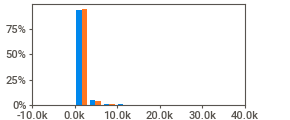
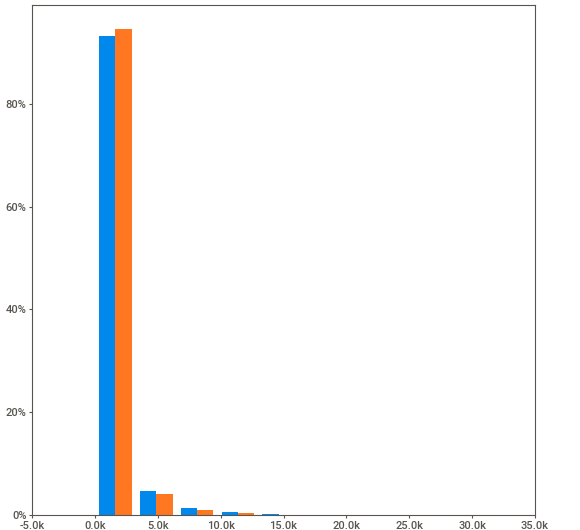
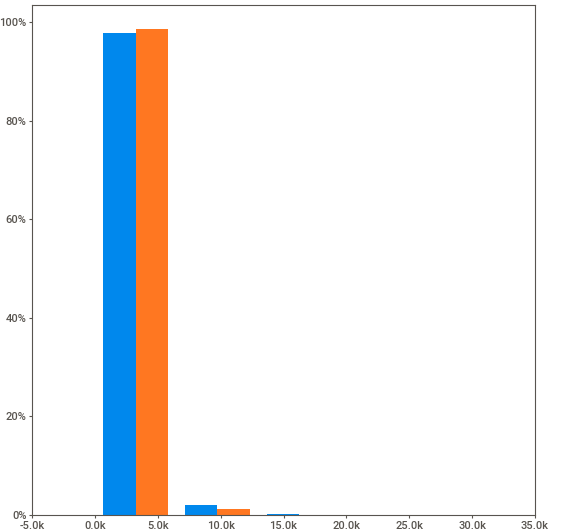
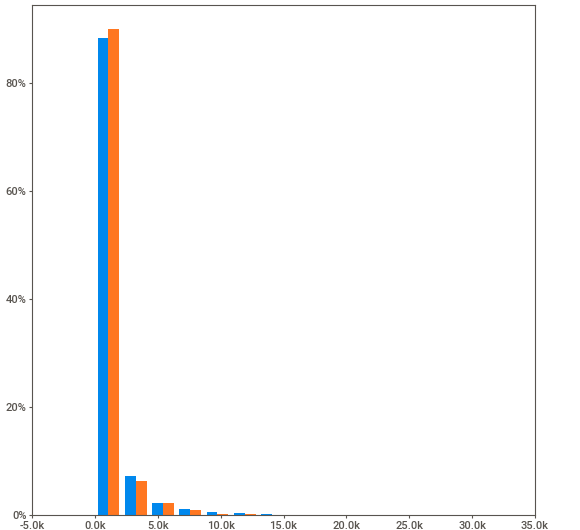
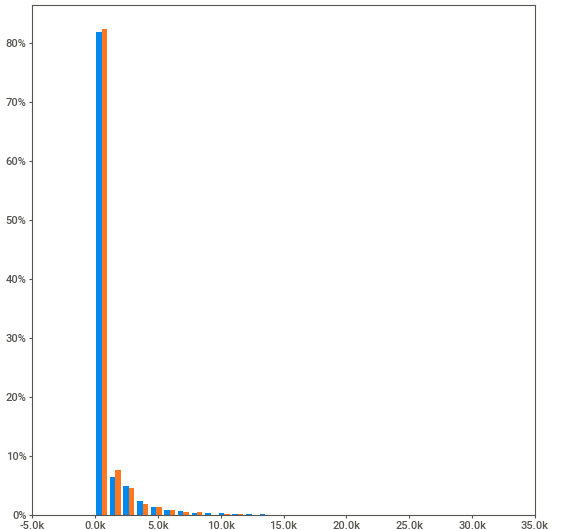
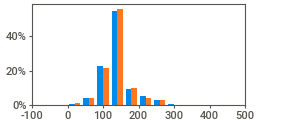
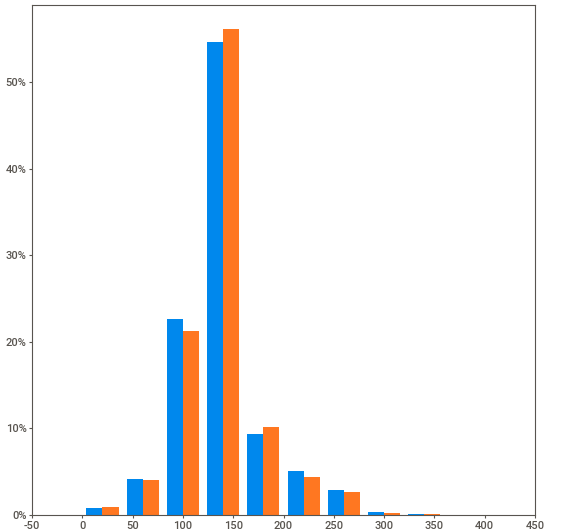
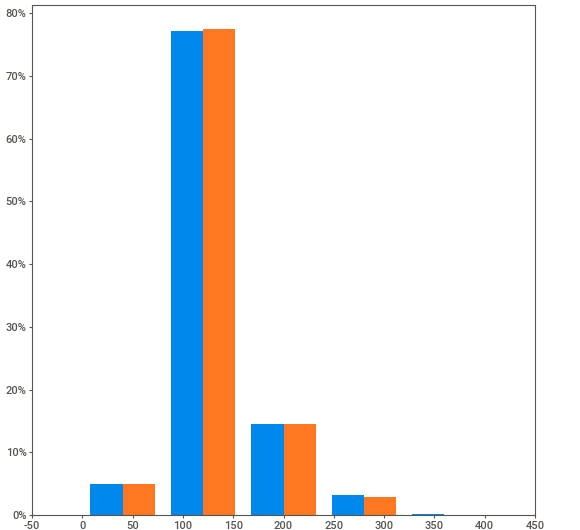
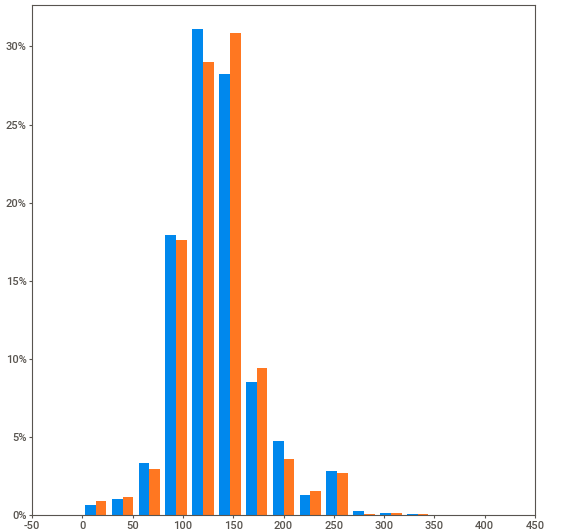
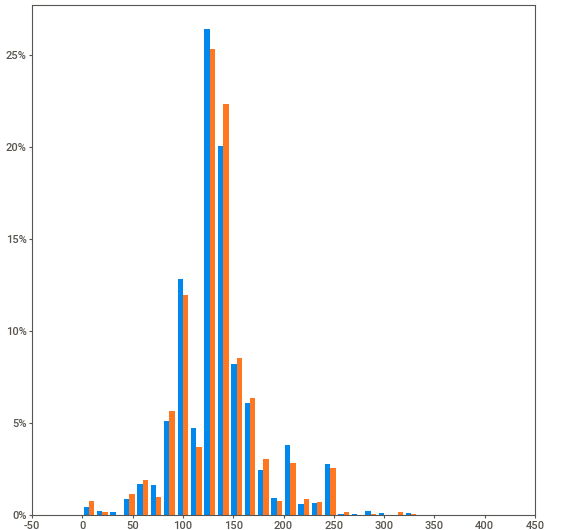
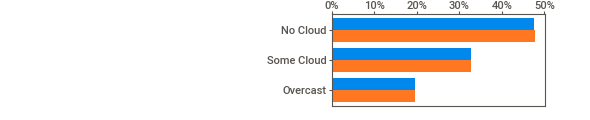
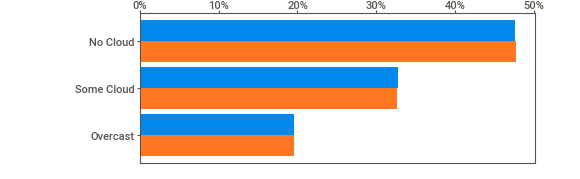
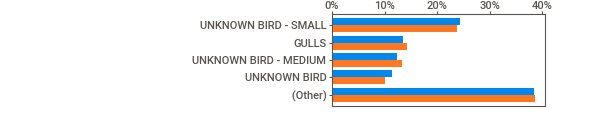
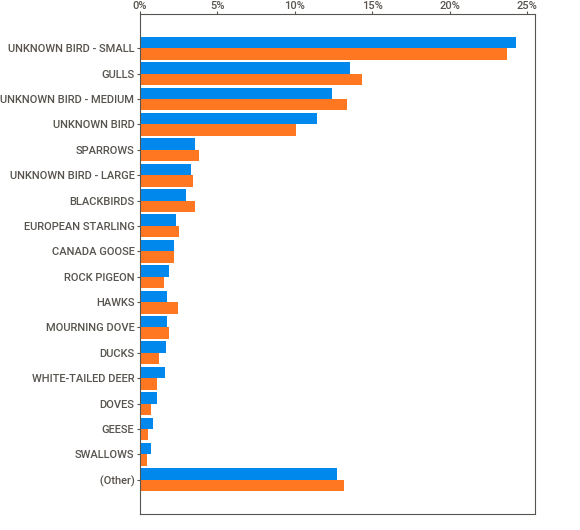
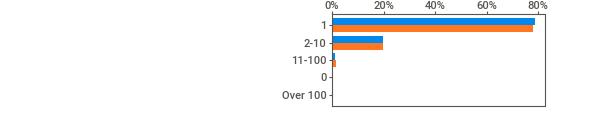
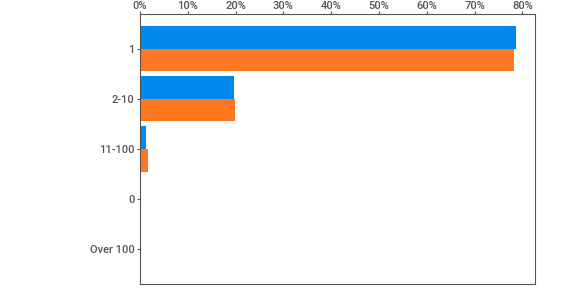
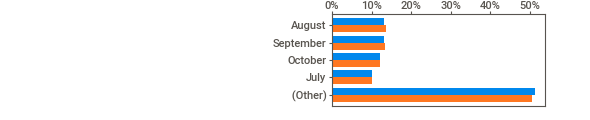
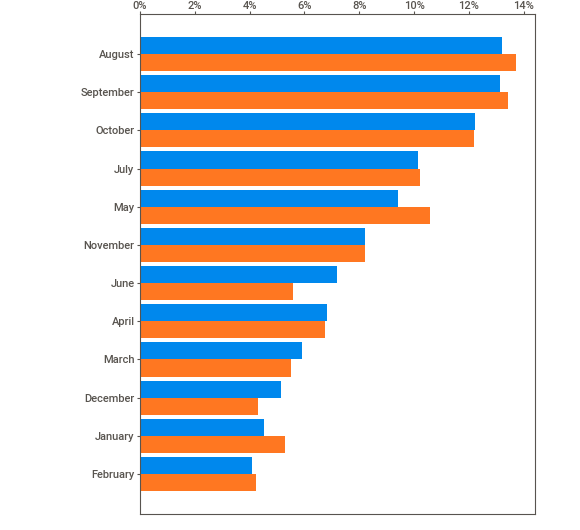
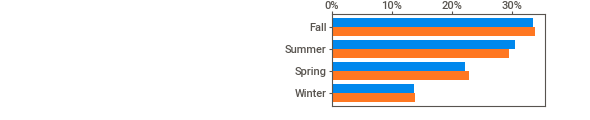
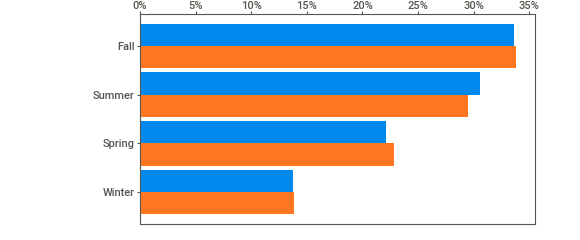
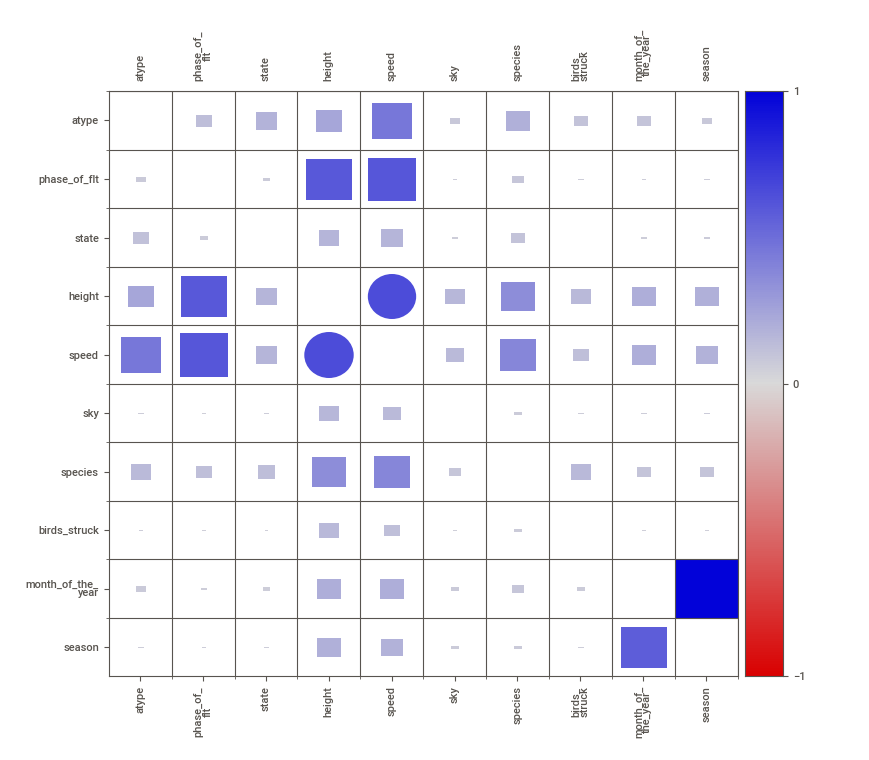
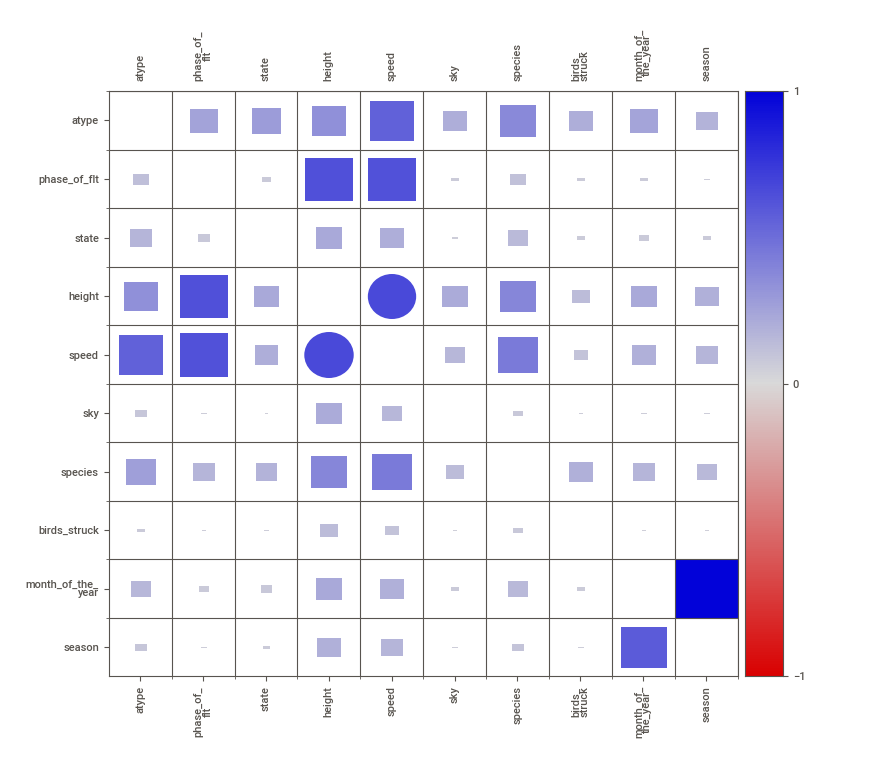

In [32]:
my_report = sv.compare(X_train,X_test)
my_report.show_notebook() 

In [40]:
std_scaler = StandardScaler() # will use in pipeline
min_max_scaler = MinMaxScaler()
cat = X_train.select_dtypes("category").columns
onehot_transformer = ColumnTransformer([("encoder",OneHotEncoder(handle_unknown="ignore"),cat)], remainder= min_max_scaler)

# Modelling

## Logistic Regression 

In [41]:
log_pipe = Pipeline([("transformer",onehot_transformer), ("log_ model", LogisticRegression())])

In [42]:
log_pipe.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder=MinMaxScaler(),
                                   transformers=[('encoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['atype', 'phase_of_flt', 'state', 'sky', 'species', 'birds_struck',
       'month_of_the_year', 'season'],
      dtype='object'))])),
                ('log_ model', LogisticRegression())])

In [43]:
ypred = log_pipe.predict(X_test)